In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)

def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
   
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
 
    downloaded.seek(0)
    return downloaded.read()
 
 
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status
 
 
def get_file_id(name):
    return get_matching_files(name)[0]['id']
 
 
def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)
 
 
def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
       
 
def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
 
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]
 
    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

In [0]:
example_file_name = 'all64_x.npy'
example_file_id = get_file_id(example_file_name)
 
move_from_drive_to_disk([example_file_name], [example_file_name])

Downloaded 104857601/295096448 bytes
Downloaded 209715202/295096448 bytes
Downloaded 295096448/295096448 bytes


In [0]:
example_file_name = 'all64_y.npy'
example_file_id = get_file_id(example_file_name)
 
move_from_drive_to_disk([example_file_name], [example_file_name])

Downloaded 2881928/2881928 bytes


In [0]:
import os
os.listdir()

['.config',
 'all64_x.npy',
 'all_y_M.npy',
 'all64_y.npy',
 'adc.json',
 'all_x_M.npy',
 'sample_data']

In [0]:
import numpy as np
import keras
from keras.layers import Dense, Conv2D, MaxPool2D,Flatten, MaxPooling2D,Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
#from keras import optimizers
from keras.optimizers import SGD

In [0]:
x = np.load('all64_x.npy')
y = np.load('all64_y.npy')
print(x.shape, 'x')
print(y.shape, 'y')

(72045, 64, 64) x
(72045, 10) y


In [0]:
x = np.expand_dims(x, axis = 3)
x.shape

(72045, 64, 64, 1)

In [0]:
x = x/255.0

In [0]:
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(64,64,1), padding='same', activation='relu')) # 5 by 5 and add 32 kernel
model.add(Conv2D(32, (3, 3), input_shape=(64,64,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Conv2D(64, (3, 3),  padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3),  padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
 
model.add(Conv2D(128, (3,3),  padding='same', activation='relu'))
model.add(Conv2D(128, (3,3),  padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Conv2D(256, (3,3),  padding='same', activation='relu'))
model.add(Conv2D(256, (3,3),  padding='same', activation='relu'))
model.add(Conv2D(256, (3,3),  padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

W0627 10:09:06.379830 140211989628800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 10:09:06.396154 140211989628800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 10:09:06.399072 140211989628800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 10:09:06.428643 140211989628800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0627 10:09:06.536107 140211989628800 deprecation_wrapp

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
__________

In [0]:
sgd = SGD(lr = 0.00001, decay = 1e-6, momentum = 0.9, nesterov= True)

In [0]:
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

W0627 10:16:24.698122 140211989628800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0627 10:16:24.712626 140211989628800 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

In [0]:
H = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 4)

Train on 57636 samples, validate on 14409 samples
Epoch 1/4
57636/57636 [==============================] - 32s 550us/step - loss: 0.2553 - acc: 0.9181 - val_loss: 0.2315 - val_acc: 0.9291
Epoch 2/4
57636/57636 [==============================] - 31s 540us/step - loss: 0.2397 - acc: 0.9228 - val_loss: 0.2011 - val_acc: 0.9393
Epoch 3/4
57636/57636 [==============================] - 31s 538us/step - loss: 0.2287 - acc: 0.9275 - val_loss: 0.1930 - val_acc: 0.9389
Epoch 4/4
57636/57636 [==============================] - 31s 540us/step - loss: 0.2180 - acc: 0.9309 - val_loss: 0.1957 - val_acc: 0.9395


In [0]:
import matplotlib.pyplot as plt

In [0]:
history = H

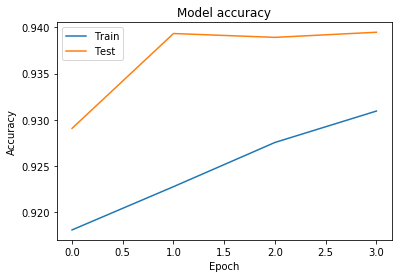

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

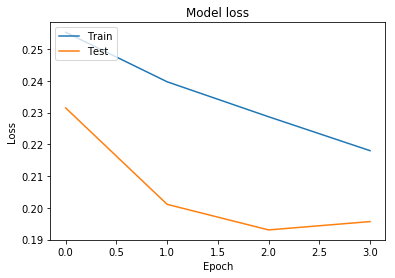

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
y_train.shape


(57636, 10)